# 1. Factor Engineering

In [ ]:
import numpy as np
from numpy.random import seed
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer


import plotly.express as px
from tqdm import tqdm
import pandas as pd
import polars as pl
import glob
import os



: 

## 1.1 Feature Generation
### 1.1.1 Book Features
We first processes raw order book data and extracts meaningful features for modeling. The following table is the summary of the feature we generated from the original datasets.


1.  **`wap1/2`**  =$ \frac{\text{ask\_price}_{1/2} \cdot \text{bid\_size}_{1/2} + \text{bid\_price}_{1/2} \cdot \text{ask\_size}_{1/2}}{\text{ask\_size}_{1/2} + \text{bid\_size}_{1/2}}$ 

Weighted Average Price at depth 1/2. This smooths out the impact of individual order prices using size as weight. It approximates the "fair" market price better than simple mid-price. Including wap2 captures more of the limit order book’s shape. 

2. **`bid_size_diff`** = $\text{bid\_size}_1 - \text{bid\_size}_2$                                                                                      

Captures the change in demand depth between level 1 and level 2. Large differences may imply lower resilience in the order book.   

3. **`ask_size_diff`** =$\text{ask\_size}_1-\text{ask\_size}_2$                                                                               

Measures ask-side change. Can signal a lack of liquidity on the sell side or increased selling pressure.                              

4. **`price_spread`** = $ \frac{\text{ask\_price}_1}{\text{bid\_price}_1} - 1$                                                                                

A measure of transaction cost and short-term illiquidity.       

5. **`order_imbalance_1/2`** =$\frac{\text{bid\_size1/2} - \text{ask\_size1/2}}{\text{bid\_size1/2} + \text{ask\_size1/2}}$                                                     

Measures demand-supply pressure at level 1/2. Positive values imply buying pressure, negative values suggest selling pressure.              

6. **`depth_ratio`** = $\frac{\text{bid\_size}_1 + \text{bid\_size}_2}{\text{ask\_size}_1 + \text{ask\_size}_2}$                                             

Compares total buy-side depth to sell-side depth. Values > 1 suggest buy-side dominance.             
                                    
7. **`total_volume`** =$ \text{bid\_size}_1 + \text{bid\_size}_2 + \text{ask\_size}_1 + \text{ask\_size}_2$                                                  

Captures overall liquidity in the limit order book. High volume typically corresponds to tighter spreads and lower volatility.            

8. **`wap_diff`**  =$ \text{wap1} - \text{wap2}$                                                                                                           
Measures how much prices diverge between the top and next levels of the book. Large values may indicate price pressure or volatility. Useful for detecting price trends or pressure. 

9. **`log_return1/2`** = $ \log\left( \frac{\text{wap1/2}_t}{\text{wap1/2}_{t-1}} \right)$                                                                        
Log return of using wap1/2. Used in volatility estimation and price dynamics modeling.                       


In [ ]:
def calc_wmp(bid_p, ask_p, bid_s, ask_s):
    return (pl.col(bid_p) * pl.col(bid_s) + pl.col(ask_p) * pl.col(ask_s)) /(pl.col(ask_s) + pl.col(bid_s))
# WAP         
def calc_wap(bid_p, ask_p, bid_s, ask_s):
    return (pl.col(bid_p) * pl.col(ask_s) + pl.col(ask_p) * pl.col(bid_s)) / (
        pl.col(bid_s) + pl.col(ask_s)
    )

# log return
def log_return(col):
    return pl.col(col).log().diff()

# realized volatility
def realized_vol(col):
    return (pl.col(col).pow(2).sum()).sqrt()


def agg_all(col: str, functions: list):
    dict = {'sum': pl.col(col).sum().alias(f"{col}_sum"),
            'mean': pl.col(col).mean().alias(f"{col}_mean"),
            'std': pl.col(col).std().alias(f"{col}_std"),
            'max': pl.col(col).max().alias(f"{col}_max"),
            'min': pl.col(col).min().alias(f"{col}_min"),
            'realized_vol':  (pl.col(col).pow(2).sum()).sqrt().alias(f"{col}_realized_vol"),
             'unique':pl.col(col).n_unique().alias(f"{col}_unique")
            }
    return [
        dict[i] for i in functions
    ]


def agg_with_rvol(col: str):
    return agg_all(col) + [
        (pl.col(col).pow(2).sum()).sqrt().alias(f"{col}_realized_vol")
    ]


def aggregate_interval_book(df: pl.DataFrame, interval_length: Optional[list] = None) -> pl.DataFrame:
    if interval_length is not None:
        start = 600 - interval_length
        df = df.filter(pl.col("seconds_in_bucket") >= start)
    extra_exprs={}
    if interval_length is None:
        extra_exprs = {
            "wap1": agg_all("wap1",['sum','std']),
        "wap2": agg_all("wap2",['sum','std']),
        "wmp1": agg_all("wmp1",['sum','std']),
        "wmp2": agg_all("wmp2",['sum','std']),
        
        "wap_balance": agg_all("wap_balance",['sum','max']),
        "price_spread": agg_all("price_spread",['sum','max']),
        "price_spread2": agg_all("price_spread2",['sum','max']),
        "bid_spread": agg_all("bid_spread",['sum','max']),
        "ask_spread": agg_all("ask_spread",['sum','max']),
        "total_volume": agg_all("total_volume",['sum','max']),
        "volume_imbalance": agg_all("volume_imbalance",['sum','max']),
        }
    agg_dict = {
        "log_return1": agg_all("log_return1",['realized_vol']),
        "log_return2": agg_all("log_return2",['realized_vol']),
        "log_return1_wmp": agg_all("log_return1_wmp",['realized_vol']),
        "log_return2_wmp": agg_all("log_return2_wmp",['realized_vol']),
    }
    agg_dict = agg_dict|extra_exprs
    df_agg = df.group_by("time_id").agg(
        [expr for exprs in agg_dict.values() for expr in exprs]
    )

    if interval_length is not None:
        df_agg = df_agg.rename({col: f"{col}_{interval_length}" if col != "time_id" else "time_id"
                                for col in df_agg.columns})

    return df_agg

In [ ]:
def preprocessor_book(file_path, time_length_list):
    stock_id = int(file_path.split('=')[1].split('.')[0])
    df = pl.read_parquet(file_path)
    df = (
        df.with_columns([
            calc_wap("bid_price1","ask_price1","bid_size1","ask_size1").alias("wap1"),
            calc_wap("bid_price2","ask_price2","bid_size2","ask_size2").alias("wap2"),
            calc_wmp("bid_price1","ask_price1","bid_size1","ask_size1").alias("wmp1"),
            calc_wmp("bid_price2","ask_price2","bid_size2","ask_size2").alias("wmp2"),
        ])
        .with_columns([
            log_return("wap1").alias("log_return1"),
            log_return("wap2").alias("log_return2"),
            log_return("wmp1").alias("log_return1_wmp"),
            log_return("wmp2").alias("log_return2_wmp"),
            (pl.col("wap1") - pl.col("wap2")).abs().alias("wap_balance"),
            ((pl.col("ask_price1") - pl.col("bid_price1")) 
             / ((pl.col("ask_price1") + pl.col("bid_price1"))/2)).alias("price_spread"),
            ((pl.col("ask_price2") - pl.col("bid_price2")) 
             / ((pl.col("ask_price2") + pl.col("bid_price2"))/2)).alias("price_spread2"),
            (pl.col("bid_price1") - pl.col("bid_price2")).alias("bid_spread"),
            (pl.col("ask_price1") - pl.col("ask_price2")).alias("ask_spread"),
            (pl.col("ask_size1")+pl.col("ask_size2")+pl.col("bid_size1")+pl.col("bid_size2")).alias("total_volume"),
            ((pl.col("ask_size1")+pl.col("ask_size2"))-(pl.col("bid_size1")+pl.col("bid_size2"))).abs().alias("volume_imbalance"),
            
            # bid_size_diff, ask_size_diff
        (pl.col("bid_size1") / pl.col("bid_size2")-1).alias("bid_size_diff"),
        (pl.col("ask_size1") / pl.col("ask_size2")-1).alias("ask_size_diff"),
 
       
        # order_imbalance_1, order_imbalance_total
        ((pl.col("bid_size1") - pl.col("ask_size1")) /
         (pl.col("bid_size1") + pl.col("ask_size1"))).alias("order_imbalance_1"),
        ((pl.col("bid_size1") + pl.col("bid_size2") - pl.col("ask_size1") - pl.col("ask_size2")) /
         (pl.col("bid_size1") + pl.col("bid_size2") + pl.col("ask_size1") + pl.col("ask_size2"))).alias("order_imbalance_total"),
        
        ])
    )
  
    # Step 2: Add dynamic (time-based) features
    df = df.sort(["time_id", "seconds_in_bucket"])

    # Step 3: Drop raw order book columns to reduce storage and redundancy
    df = df.drop([
        "ask_price1", "ask_price2", "ask_size1", "ask_size2",
        "bid_price1", "bid_price2", "bid_size1", "bid_size2"
    ])

    # Rows with null values for log_return1/2 are dropped. These nulls are a result of the `.diff()` operation within the calculation.
    merged_df = None
    for length in time_length_list:
        df_agg = aggregate_interval_book(df, length)
        merged_df = df_agg if merged_df is None else merged_df.join(
        df_agg, on="time_id", how="left")

    df_feature = aggregate_interval_book(df)

    df_feature = df_feature.join(merged_df, on="time_id", how="left")

    df_feature = df_feature.with_columns(
        (pl.lit(stock_id).cast(pl.Utf8) + "-" +
         pl.col("time_id").cast(pl.Utf8)).alias("row_id")
    )
    


    return df_feature


In [ ]:
preprocessor_book('data/optiver-realized-volatility-prediction/book_train.parquet/stock_id=0',[300,150]).head()

time_id,log_return1_realized_vol,log_return2_realized_vol,log_return1_wmp_realized_vol,log_return2_wmp_realized_vol,wap1_sum,wap1_std,wap2_sum,wap2_std,wmp1_sum,wmp1_std,wmp2_sum,wmp2_std,wap_balance_sum,wap_balance_max,price_spread_sum,price_spread_max,price_spread2_sum,price_spread2_max,bid_spread_sum,bid_spread_max,ask_spread_sum,ask_spread_max,total_volume_sum,total_volume_max,volume_imbalance_sum,volume_imbalance_max,log_return1_realized_vol_300,log_return2_realized_vol_300,log_return1_wmp_realized_vol_300,log_return2_wmp_realized_vol_300,log_return1_realized_vol_150,log_return2_realized_vol_150,log_return1_wmp_realized_vol_150,log_return2_wmp_realized_vol_150,row_id
i16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,str
5,0.004499,0.006999,0.005466,0.006119,303.125061,0.000693,303.105539,0.000781,303.134863,0.000637,303.146936,0.000652,0.117051,0.001414,0.257255,0.001393,0.355451,0.001699,0.053006,0.000672,-0.045557,-0.000052,97696,762,40738,518,0.002953,0.004863,0.003873,0.004492,0.001721,0.004114,0.002599,0.003368,"""0-5"""
11,0.003966,0.004628,0.003873,0.003877,200.047768,0.000262,200.041171,0.000272,200.035611,0.000298,200.040851,0.000278,0.042312,0.000639,0.078836,0.000903,0.134182,0.001104,0.028358,0.000652,-0.027001,-0.00005,82290,876,28410,481,0.000981,0.002009,0.001308,0.001637,0.000918,0.001883,0.001169,0.001438,"""0-11"""
16,0.002451,0.00496,0.002658,0.004693,187.913849,0.000864,187.939824,0.000862,187.923063,0.00067,187.897375,0.000779,0.062228,0.001135,0.13633,0.001149,0.210563,0.001915,0.036955,0.00067,-0.037243,-0.000048,78274,758,26586,579,0.001295,0.003196,0.001815,0.002354,0.001158,0.002972,0.001703,0.001947,"""0-16"""
31,0.003742,0.00409,0.003071,0.004029,119.859781,0.000757,119.835941,0.000656,119.870163,0.000606,119.88424,0.000733,0.045611,0.001082,0.103252,0.001622,0.139066,0.002039,0.022764,0.000694,-0.013001,-0.000046,52232,912,17546,576,0.001776,0.002713,0.001312,0.001814,0.000993,0.001424,0.000441,0.000636,"""0-31"""
62,0.00321,0.003988,0.002414,0.00348,175.932865,0.000258,175.934256,0.000317,175.928283,0.000215,175.912533,0.000312,0.044783,0.000724,0.069901,0.000793,0.122698,0.001166,0.033565,0.000466,-0.019206,-0.000047,60407,738,21797,424,0.00152,0.002188,0.001625,0.002443,0.001378,0.000966,0.001197,0.001488,"""0-62"""


### 1.1.2 10-Minute Time Window Book Features
This code performs 10min-time-interval aggregation on order book data. It groups data by time_id within specified time intervals and computes key features such as realized volatility, logarithmic price range, and various mean values related to prices, order imbalances, and volume. The aggregated features are then saved as Parquet files named by stock ID, enabling efficient downstream analysis and modeling. 

### 1.1.3 150-Second Time Segment Book Features
This code processes order book data by dividing each trading period into fixed-length intervals (in this case, 4 intervals of 150 seconds each). For each stock file, it aggregates features separately for each time interval using the aggregate_interval_book function, and then merges these interval-based feature sets into a single DataFrame keyed by time_id. The resulting combined features capture finer-grained temporal dynamics within the trading period. Finally, the aggregated data is saved as Parquet files organized by stock ID.

### 1.1.4 Trade Features 
This code processes trade data for stocks, computing additional features such as average trade size per order and the logarithmic return of trade prices. The logarithmic return is calculated as the log of the ratio between the current price and the previous price. Rows with null values resulting from this calculation (due to missing previous prices) are removed to ensure data quality. The cleaned and enriched DataFrame is then saved as Parquet files, organized by stock ID.

### 1.1.5 10-Minute Time Window Trade Features
This code aggregates trade data into 10-minute intervals by grouping on time_id. For each interval, it calculates various statistical features, including realized volatility from squared log returns, price range, mean price, mean order size, total traded size, and standard deviation of trade sizes. The processed features are saved to separate Parquet files for each stock, enabling efficient downstream analysis.

In [ ]:
def aggregate_interval_trade(df: pl.DataFrame, interval_length: Optional[list] = None) -> pl.DataFrame:
    if interval_length is not None:
        start = 600 - interval_length
        df = df.filter(pl.col("seconds_in_bucket") >= start)

    extra_exprs={}
    if interval_length is None:
        extra_exprs = {
            "size_per_order": agg_all("size_per_order",['mean']),
            "size": agg_all("size",['sum','min','max']),
            "order_count": agg_all("order_count",['max']),
            "amount":agg_all("amount",['sum','max','min'])
        }
        
    agg_dict = {
        "trade_log_return": agg_all("trade_log_return",['realized_vol']),
        "order_count":agg_all("order_count",['sum']),
        "seconds_in_bucket": agg_all("seconds_in_bucket",['unique'])   
    }
    vals = list(agg_dict.values()) + list(extra_exprs.values())
    df_agg = df.group_by("time_id").agg(
        [expr for exprs in vals for expr in exprs]
    )
    if interval_length is not None:
        df_agg = df_agg.rename({col: f"{col}_{interval_length}" if col != "time_id" else "time_id"
                                for col in df_agg.columns})

    return df_agg

In [ ]:
def preprocessor_trade(file_path, time_length_list):
    stock_id = int(file_path.split('=')[1].split('.')[0])
    df = pl.read_parquet(file_path)
    df = df.sort(["time_id", "seconds_in_bucket"])

    df = df.with_columns([
        # size_per_order
        (pl.col("size")/pl.col("order_count")).alias("size_per_order"),
        # trade_log_return
         (pl.col("price").diff().over("time_id")).alias("trade_log_return"),
         pl.col("size").mean().alias("size_mean"),
          (pl.col("price")* pl.col("size")).alias("amount")
        
    ])

    merged_df = None
    for length in time_length_list:
        
        df_agg = aggregate_interval_trade(df, length)
        merged_df = df_agg if merged_df is None else merged_df.join(df_agg, on="time_id", how="left")

    df_feature = aggregate_interval_trade(df)  
    df_feature = df_feature.join(merged_df, on="time_id", how="left")

    df_feature = df_feature.with_columns(
        (pl.lit(stock_id).cast(pl.Utf8) + "-" + pl.col("time_id").cast(pl.Utf8)).alias("row_id")
    )
    

    return df_feature


In [ ]:
preprocessor_trade('data/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=0',[300,150]).head()

time_id,trade_log_return_realized_vol,order_count_sum,seconds_in_bucket_unique,size_per_order_mean,size_sum,size_min,size_max,order_count_max,amount_sum,amount_max,amount_min,trade_log_return_realized_vol_300,order_count_sum_300,seconds_in_bucket_unique_300,trade_log_return_realized_vol_150,order_count_sum_150,seconds_in_bucket_unique_150,row_id
i16,f32,i64,u32,f64,i32,i32,i32,i16,f64,f64,f64,f32,i64,u32,f32,i64,u32,str
5,0.002013,110,40,23.118036,3179,1,499,12,3190.139181,500.592485,1.002715,0.001313,54,21,0.001063,37,14,"""0-5"""
11,0.000901,57,30,20.061111,1289,1,280,6,1289.353432,280.020061,0.999724,0.000588,36,16,0.000501,22,10,"""0-11"""
16,0.00196,68,25,25.548476,2161,1,391,8,2158.608928,390.44356,0.999928,0.001135,38,12,0.001046,33,9,"""0-16"""
31,0.001559,59,15,33.507407,1962,5,450,15,1959.605547,449.087539,4.991672,0.001088,46,9,0.0008,11,3,"""0-31"""
62,0.000871,89,22,16.177243,1791,1,341,17,1790.254496,340.804756,0.999231,0.000453,54,11,0.00036,14,4,"""0-62"""


In [ ]:
def preprocessor(list_book_files, list_trade_files, target_data, time_length_list, train=True) -> pd.DataFrame:
    dfs = []
    for book_file, trade_file in tqdm(zip(list_book_files, list_trade_files)):
        df_book = preprocessor_book(book_file, time_length_list)
        df_trade = preprocessor_trade(trade_file, time_length_list)
        df_tmp = df_book.join(df_trade, on="row_id", how="left")

        dfs.append(df_tmp)

    df = pl.concat(dfs)
    target_data = target_data.with_columns(
        (pl.col("stock_id").cast(pl.Utf8) + "-" +
         pl.col("time_id").cast(pl.Utf8)).alias("row_id")
    )
    if train:
        target_data = target_data.select([
            "row_id",
            "target"
        ])
    else:
        target_data = target_data.select([
            "row_id",

        ])
    df = df.with_columns(
        pl.col("row_id").str.split(
            "-").list.get(0).cast(pl.Int64).alias("stock_id")
    )
    df = target_data.join(df, on="row_id", how="left")
    df = df.to_pandas()
    df.replace([np.inf, -np.inf], np.nan,inplace=True)

    
    return df

### Training data preprocess

### Test data preprocess


In [ ]:
list_book_test= glob.glob(
    'data/optiver-realized-volatility-prediction/book_test.parquet/*')
list_trade_test = glob.glob(
    'data/optiver-realized-volatility-prediction/trade_test.parquet/*')
test_data = pl.read_csv(
    'data/optiver-realized-volatility-prediction/test.csv')


## K-fold based on K-means

In [ ]:
train = pd.read_csv("data/optiver-realized-volatility-prediction/train.csv")
train_p = train.pivot(
    index='time_id',
    columns='stock_id',
    values='target'
)

corr = train_p.corr()
ids = corr.index
cluster_num = 7
kmeans = KMeans(n_clusters=cluster_num, random_state=0,
                n_init=10).fit(corr.values)
labels = kmeans.labels_
cluster_stocks = {}
for i in range(cluster_num):
    cluster_stocks[i] = [ids[j] for j in range(len(ids)) if labels[j] == i]


def generate_cluster_features(df: pd.DataFrame, cluster_stocks: dict) -> pd.DataFrame:
    cluster_features = {}

    for c, stocks in cluster_stocks.items():
        #print(f"Cluster {c} has {len(stocks)} stocks: {stocks}")
        if len(stocks)<10:
            cluster_df = df
        else:
            cluster_df = df[df['stock_id'].isin(stocks)]
        numeric_cols = ['log_return1_realized_vol', 'total_volume_sum', 'size_sum', 'order_count_sum',
                        'price_spread_sum', 'bid_spread_sum', 'ask_spread_sum', 'volume_imbalance_sum','size_tau2']
        cluster_avg = (
            cluster_df.groupby("time_id")[numeric_cols]
            .mean()
        )

        cluster_avg = cluster_avg.rename(
            columns={col: f"cluster_{c}_{col}" for col in numeric_cols}
        )
        cluster_features[c] = cluster_avg

    cluster_list = list(cluster_features.values())
    result = cluster_list[0]

    for cl in cluster_list[1:]:
        result = result.merge(cl, on='time_id', how='left')

    return result


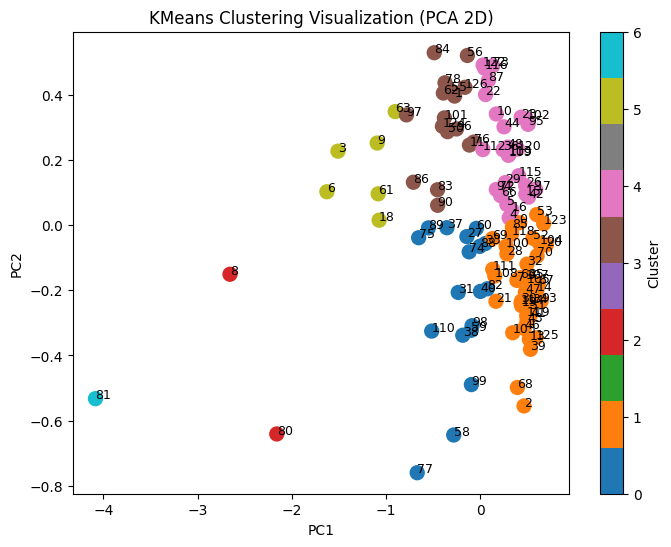

In [ ]:
pca = PCA(n_components=2)
corr_2d = pca.fit_transform(corr.values)

plt.figure(figsize=(8,6))
plt.scatter(corr_2d[:,0], corr_2d[:,1], c=kmeans.labels_, cmap='tab10', s=100)
for i, stock_id in enumerate(corr.index):
    plt.text(corr_2d[i,0], corr_2d[i,1], str(stock_id), fontsize=9)
plt.title("KMeans Clustering Visualization (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
list_book_train = glob.glob(
    'data/optiver-realized-volatility-prediction/book_train.parquet/*')
list_trade_train = glob.glob(
    'data/optiver-realized-volatility-prediction/trade_train.parquet/*')
train_data = pl.read_csv(
    'data/optiver-realized-volatility-prediction/train.csv')

time_length_list = [500,400,300,200,100]

In [ ]:
#list_book_test,list_trade_test,test_data = list_book_train,list_trade_train,train_data.clone().drop('target')

df_train = preprocessor(list_book_train, list_trade_train,train_data,time_length_list)
df_test = preprocessor(list_book_test,list_trade_test,test_data,time_length_list,train=False)



NameError: name 'preprocessor' is not defined

In [ ]:
def get_time_stock(df):
    vol_cols = ['log_return1_realized_vol', 'log_return2_realized_vol', 'log_return1_realized_vol_400', 'log_return2_realized_vol_400', 
                'log_return1_realized_vol_300', 'log_return2_realized_vol_300', 'log_return1_realized_vol_200', 'log_return2_realized_vol_200', 
                'trade_log_return_realized_vol', 'trade_log_return_realized_vol_400', 'trade_log_return_realized_vol_300', 'trade_log_return_realized_vol_200']


    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df
    

In [ ]:
df_train=get_time_stock(df_train)
df_test=get_time_stock(df_test)

In [ ]:
df_train['size_tau'] = np.sqrt( 1/ df_train['seconds_in_bucket_unique'] )
df_test['size_tau'] = np.sqrt( 1/ df_test['seconds_in_bucket_unique'] )

df_train['size_tau_400'] = np.sqrt( 1/ df_train['seconds_in_bucket_unique_400'] )
df_test['size_tau_400'] = np.sqrt( 1/ df_test['seconds_in_bucket_unique_400'] )
df_train['size_tau_300'] = np.sqrt( 1/ df_train['seconds_in_bucket_unique_300'] )
df_test['size_tau_300'] = np.sqrt( 1/ df_test['seconds_in_bucket_unique_300'] )

df_train['size_tau_200'] = np.sqrt( 1/ df_train['seconds_in_bucket_unique_200'] )
df_test['size_tau_200'] = np.sqrt( 1/ df_test['seconds_in_bucket_unique_200'] )

df_train['size_tau2'] = np.sqrt( 1/ df_train['order_count_sum'] )
df_test['size_tau2'] = np.sqrt( 1/ df_test['order_count_sum'] )

df_train['size_tau2_400'] = np.sqrt( 0.33/ df_train['order_count_sum'] )
df_test['size_tau2_400'] = np.sqrt( 0.33/ df_test['order_count_sum'] )
df_train['size_tau2_300'] = np.sqrt( 0.5/ df_train['order_count_sum'] )
df_test['size_tau2_300'] = np.sqrt( 0.5/ df_test['order_count_sum'] )

df_train['size_tau2_200'] = np.sqrt( 0.66/ df_train['order_count_sum'] )
df_test['size_tau2_200'] = np.sqrt( 0.66/ df_test['order_count_sum'] )

# delta tau
df_train['size_tau2_d'] = df_train['size_tau2_400'] - df_train['size_tau2']
df_test['size_tau2_d'] = df_test['size_tau2_400'] - df_test['size_tau2']


train_cluster = generate_cluster_features(df_train, cluster_stocks).reset_index()
train = pd.merge(df_train,train_cluster,how='left',on='time_id')
test_cluster = generate_cluster_features(df_test, cluster_stocks).reset_index()
df_test['time_id'] = df_test['row_id'].str.split("-").str[1]
df_test['time_id'] = df_test['time_id'].astype(int)
test_cluster['time_id'] = test_cluster['time_id'].astype(int)

test =  pd.merge(df_test,test_cluster,how='left',on='time_id')
test.head()

,row_id,time_id,log_return1_realized_vol,log_return2_realized_vol,log_return1_wmp_realized_vol,log_return2_wmp_realized_vol,wap1_sum,wap1_std,wap2_sum,wap2_std,...,cluster_5_size_tau2,cluster_6_log_return1_realized_vol,cluster_6_total_volume_sum,cluster_6_size_sum,cluster_6_order_count_sum,cluster_6_price_spread_sum,cluster_6_bid_spread_sum,cluster_6_ask_spread_sum,cluster_6_volume_imbalance_sum,cluster_6_size_tau2
0,0-4,4,0.000294,0.000252,0.000245,0.000027,3.001215,0.00017,3.00165,0.000153,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0-32,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0-34,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
nfolds = 5
n_time = train_p.shape[0]
distance_sum=[]
distance_sum = [np.zeros(n_time-nfolds) for _ in range(nfolds)]
selected_mat=[]
train_p = train_p.fillna(train_p.mean())
target_mat = train_p.values
target_mat = MinMaxScaler(feature_range=(-1, 1)).fit_transform(target_mat)
target_mat = np.c_[target_mat, range(n_time)]
num_per_fold = int(n_time/nfolds)

# Random select points to be the initial centers
centers = np.random.choice(np.array(n_time), size=nfolds, replace=False)
centers = np.sort(centers)[::-1]
# The index of rows that have been considered
ind_values = [[centers[i]] for i in range(nfolds)]

for i in range(nfolds):
    # The row that have been considered

    selected_mat.append(target_mat[ind_values[i], :])
 
    target_mat = np.delete(target_mat, obj=ind_values[i], axis=0)
for i in range(num_per_fold):

    for j in range(nfolds):
        threshold = np.random.uniform(0, 1, 1)
        # Match the size foe future matrix calculation
       
        selected_mat[j] = np.tile(selected_mat[j], (target_mat.shape[0], 1))
        distance_sum[j] += np.sum((target_mat[:, :-1] -
                               selected_mat[j][:, :-1])**2, axis=1)
        prob_vec = distance_sum[j]/np.sum(distance_sum[j])
        cum_prob = 0
        line_idx = 0
        for val in prob_vec:
            cum_prob += val
            if (cum_prob > threshold):  # the column was selected
                break
            line_idx += 1
        cum_prob = 0

        # Update parameters
        
        for n in range(nfolds):
            distance_sum[n] = np.delete(distance_sum[n].copy(), line_idx)
        centers[j] = line_idx
        selected_mat[j] = target_mat[line_idx, :]
        ind_values[j].append(target_mat[line_idx, -1])
        target_mat = np.delete(target_mat, obj=line_idx, axis=0)
  
    if target_mat.shape[0]==0:
        break
    
for ind in range(nfolds):
    ind_values[ind] = train_p.index[[int(term) for term in ind_values[ind]]]
    

# 2.Model Training

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

import lightgbm as lgb
import torch

In [ ]:
def rmspe(y_true, y_pred):
    # Root mean squared percentage error
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

def RMSPELoss(y_pred, y_true):
    return torch.sqrt(torch.mean( ((y_true - y_pred) / y_true) ** 2 )).clone()

def rmspe_feval(y_pred, dataset):
    y_true = dataset.get_label()

    return 'RMSPE', round(rmspe(y_true = y_true, y_pred = y_pred),5), False

In [ ]:
'''stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)
for idx_1, idx_2 in kf.split(df_train):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_enc'] = tmp'''

"stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() \ndf_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set\n\ntmp = np.repeat(np.nan, df_train.shape[0])\nkf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)\nfor idx_1, idx_2 in kf.split(df_train):\n    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()\n\n    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)\ndf_train['stock_id_target_enc'] = tmp"

In [ ]:
params = {
    "objective": "rmse",
    "metric": "rmse",
   
    "boosting_type": "gbdt",
  #   'min_data_in_leaf':500,
    'max_depth': -1,
    'subsample_freq': 4,
 
    'feature_fraction': 0.3,
    'bagging_fraction': 0.75,
    'learning_rate': 0.02,

    'lambda_l1': 0.5,
    'lambda_l2': 1.0,

}
def train_and_pred(train,test,params,n_splits = 5):
    feature_importances = pd.DataFrame()
    fold_scores=[]
    
    X = train.drop(['target'],axis=1)
    y = train['target']
    
    kfold = KFold(n_splits , random_state = 42, shuffle = True)
    test_pred= np.zeros(test.shape[0])
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f"Fold {fold+1}")
        
        X_train, y_train = X.loc[train_idx], y[train_idx]
        X_val, y_val = X.loc[val_idx], y[val_idx]

        weights_train = 1 / np.square(y_train.values)
        weights_val = 1 / np.square(y_val.values)
      
        '''X_train_cl = generate_cluster_features(X_train, cluster_stocks)
        X_val_cl = generate_cluster_features(X_val, cluster_stocks)
        X_train =  pd.merge(X_train,X_train_cl,how='left',on='time_id')
        X_val =  pd.merge(X_val,X_val_cl,how='left',on='time_id')
        '''
        X_train = X_train.drop(['row_id','time_id'],axis=1)
        X_val = X_val.drop(['row_id','time_id'],axis=1)
        features = X_train.columns.tolist()
        lgb_train = lgb.Dataset(X_train, label=y_train, weight=weights_train,
                                categorical_feature=['stock_id'])
        lgb_val = lgb.Dataset(X_val, label=y_val, weight=weights_val,
                            reference=lgb_train)
        model = lgb.train(
            params=params,
            train_set=lgb_train,
            num_boost_round=5000,
            feval=rmspe_feval,
            valid_sets=[lgb_train, lgb_val],
            callbacks=[lgb.early_stopping(
                stopping_rounds=50), lgb.log_evaluation(100)],

        )  

        y_pred = model.predict(X_val, num_iteration=model.best_iteration)
   
        test_pred += model.predict(test[features]) / 5
        rmse = rmspe(y_true=y_val, y_pred=y_pred)
        

        fold_scores.append(round(rmse,5))

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X_train.columns
        fold_importance["importance"] = model.feature_importance(
            importance_type='split')
        fold_importance["fold"] = fold + 1

        feature_importances = pd.concat(
            [feature_importances, fold_importance], axis=0)

    print(f"Average RMSE: {np.mean(fold_scores):.5f}")
    return feature_importances, test_pred

feature_importances,test_pred =  train_and_pred(train,test,params,n_splits = 5)

Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54115
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 242
[LightGBM] [Info] Start training from score 0.001797
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.000513589	training's RMSPE: 0.23788	valid_1's rmse: 0.00053701	valid_1's RMSPE: 0.24774
[200]	training's rmse: 0.000462895	training's RMSPE: 0.2144	valid_1's rmse: 0.000492626	valid_1's RMSPE: 0.22727
[300]	training's rmse: 0.000449824	training's RMSPE: 0.20835	valid_1's rmse: 0.000480582	valid_1's RMSPE: 0.22171
[400]	training's rmse: 0.000441074	training's RMSPE: 0.2043	valid_1's rmse: 0.000473008	valid_1's RMSPE: 0.21822
[500]	training's rmse: 0.000434233	training's RMSPE: 0.20113	valid_1's

## Feature importance

In [ ]:
'''mean_importance = feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False)

sns.barplot(x=mean_importance[-20:],
    y=mean_importance.index[-20:])
plt.title('Mean Feature Importance by Folds (least important)')
plt.show()'''

'mean_importance = feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False)\n\nsns.barplot(x=mean_importance[-20:],\n    y=mean_importance.index[-20:])\nplt.title(\'Mean Feature Importance by Folds (least important)\')\nplt.show()'

In [ ]:
'''sns.barplot(x=mean_importance[:20],
    y=mean_importance.index[:20])
plt.title('Mean Feature Importance by Folds (most important)')
plt.show()'''


"sns.barplot(x=mean_importance[:20],\n    y=mean_importance.index[:20])\nplt.title('Mean Feature Importance by Folds (most important)')\nplt.show()"

In [ ]:
from numpy.random import seed
import tensorflow as tf

from tensorflow import keras
from keras import backend as K

tf.random.set_seed(42)
def rmse_keras(y_true, y_pred):
    return K.sqrt(K.mean(K.square( (y_true - y_pred)/ y_true )))
    
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=7, verbose=0,
    mode='min')

In [ ]:
colNames = df_train.columns.tolist()
colNames.remove('row_id')
colNames.remove('target')
colNames.remove('time_id')
colNames.remove('stock_id')


In [ ]:
qt_train = []

train_nn=df_train[colNames].copy()
test_nn=df_test[colNames].copy()

for col in colNames:

    qt = QuantileTransformer(random_state=42,n_quantiles=2000, output_distribution='normal')
    train_nn[col] = qt.fit_transform(train_nn[[col]])
    test_nn[col] = qt.transform(test_nn[[col]])    
    qt_train.append(qt)
    



In [ ]:
train_nn[['stock_id','time_id','target']]=df_train[['stock_id','time_id','target']]
train_cluster = generate_cluster_features(df_train, cluster_stocks).reset_index()
test_cluster = generate_cluster_features(df_test, cluster_stocks).reset_index()
df_test['time_id'] = df_test['row_id'].str.split("-").str[1]
df_test['time_id'] = df_test['time_id'].astype(int)
test_cluster['time_id'] = test_cluster['time_id'].astype(int)
test_nn[['stock_id','time_id']]=df_test[['stock_id','time_id']]
'''
train_nn[['stock_id','time_id','target']]=df_train[['stock_id','time_id','target']]
train_cluster = generate_cluster_features(df_train, cluster_stocks).reset_index()'''
train_nn = pd.merge(train_nn,train_cluster,how='left',on='time_id')
test_nn = pd.merge(test_nn,test_cluster,how='left',on='time_id')


/tmp/ipykernel_13/4193384786.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_nn[['stock_id','time_id','target']]=df_train[['stock_id','time_id','target']]
/tmp/ipykernel_13/4193384786.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_nn[['stock_id','time_id','target']]=df_train[['stock_id','time_id','target']]
/tmp/ipykernel_13/4193384786.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

In [ ]:
train_cluster

,time_id,cluster_0_log_return1_realized_vol,cluster_0_total_volume_sum,cluster_0_size_sum,cluster_0_order_count_sum,cluster_0_price_spread_sum,cluster_0_bid_spread_sum,cluster_0_ask_spread_sum,cluster_0_volume_imbalance_sum,cluster_0_size_tau2,...,cluster_5_size_tau2,cluster_6_log_return1_realized_vol,cluster_6_total_volume_sum,cluster_6_size_sum,cluster_6_order_count_sum,cluster_6_price_spread_sum,cluster_6_bid_spread_sum,cluster_6_ask_spread_sum,cluster_6_volume_imbalance_sum,cluster_6_size_tau2
0,5,0.004872,243938.84,34805.44,606.36,0.264870,0.054052,-0.055414,99555.00,0.055045,...,0.060859,0.004564,3.456186e+06,37392.944444,311.500000,0.266546,0.097849,-0.105899,8.243767e+05,0.070290
1,11,0.003074,290943.32,11826.40,226.68,0.116857,0.036446,-0.036836,85056.28,0.080612,...,0.086877,0.003627,5.159010e+06,12386.777778,157.388889,0.141960,0.075472,-0.075217,1.319986e+06,0.100094
2,16,0.002754,393005.60,12940.56,190.80,0.102819,0.041222,-0.040275,109140.72,0.088701,...,0.085441,0.003565,6.443588e+06,15469.722222,146.000000,0.172422,0.100452,-0.097067,1.649668e+06,0.111269
3,31,0.002709,283044.96,10313.44,191.08,0.129462,0.035683,-0.036416,88984.08,0.092025,...,0.093941,0.003611,3.376000e+06,17120.888889,146.666667,0.152984,0.081375,-0.083333,6.566752e+05,0.098094
4,62,0.002379,275719.00,9913.92,191.32,0.098860,0.034108,-0.032763,86559.32,0.090439,...,0.090875,0.002842,4.570958e+06,14141.277778,131.111111,0.132486,0.072047,-0.073787,1.017866e+06,0.105215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,32751,0.003303,338324.60,15640.00,336.32,0.163817,0.042633,-0.043783,148267.72,0.065250,...,0.067603,0.003442,4.871410e+06,28828.833333,244.222222,0.175172,0.090258,-0.095934,7.220615e+05,0.084764
3826,32753,0.003080,346881.64,16640.52,351.96,0.098663,0.032366,-0.033313,103372.36,0.072102,...,0.070870,0.003170,6.858452e+06,18563.111111,229.555556,0.141583,0.082203,-0.079893,1.640696e+06,0.080604
3827,32758,0.002817,309286.04,11447.68,185.52,0.138975,0.038987,-0.039310,88230.84,0.102183,...,0.099296,0.003202,6.210604e+06,21978.388889,182.444444,0.168502,0.091938,-0.094530,1.979517e+06,0.112833
3828,32763,0.003409,589748.32,35193.24,462.52,0.136002,0.059267,-0.060566,158674.56,0.054565,...,0.055242,0.004474,1.015840e+07,57377.166667,337.611111,0.213039,0.119058,-0.122507,3.010704e+06,0.061386


In [ ]:

def swish(x, beta = 1):
    return (x * K.sigmoid(beta * x))

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'swish': Activation(swish)})

hidden_units = (128,64,32)
stock_embedding_size = 24
cat_data = train_nn['stock_id']

def base_model():
    
    # Each instance will consist of two inputs: a single user id, and a single movie id
    stock_id_input = keras.Input(shape=(1,), name='stock_id')
    num_input = keras.Input(shape=(242,), name='num_data')


    #embedding, flatenning and concatenating
    stock_embedded = keras.layers.Embedding(max(cat_data)+1, stock_embedding_size, 
                                           input_length=1, name='stock_embedding')(stock_id_input)
    stock_flattened = keras.layers.Flatten()(stock_embedded)
    out = keras.layers.Concatenate()([stock_flattened, num_input])
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:

        out = keras.layers.Dense(n_hidden, activation='swish')(out)
        

    #out = keras.layers.Concatenate()([out, num_input])

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
    
    model = keras.Model(
    inputs = [stock_id_input, num_input],
    outputs = out,
    )
    
    return model

In [ ]:
train_nn

,log_return1_realized_vol,log_return2_realized_vol,log_return1_wmp_realized_vol,log_return2_wmp_realized_vol,wap1_sum,wap1_std,wap2_sum,wap2_std,wmp1_sum,wmp1_std,...,cluster_5_size_tau2,cluster_6_log_return1_realized_vol,cluster_6_total_volume_sum,cluster_6_size_sum,cluster_6_order_count_sum,cluster_6_price_spread_sum,cluster_6_bid_spread_sum,cluster_6_ask_spread_sum,cluster_6_volume_imbalance_sum,cluster_6_size_tau2
0,-0.003362,0.354438,0.247420,0.187837,-0.472177,-0.211403,-0.472481,-0.119330,-0.472139,-0.311462,...,0.060859,0.004564,3.456186e+06,37392.944444,311.500000,0.266546,0.097849,-0.105899,8.243767e+05,0.070290
1,-0.201664,-0.297873,-0.304567,-0.530011,-1.341469,-1.683361,-1.341531,-1.764650,-1.341741,-1.469609,...,0.086877,0.003627,5.159010e+06,12386.777778,157.388889,0.141960,0.075472,-0.075217,1.319986e+06,0.100094
2,-0.964602,-0.187208,-0.949768,-0.236531,-1.486974,0.092040,-1.486544,0.029785,-1.486964,-0.243400,...,0.085441,0.003565,6.443588e+06,15469.722222,146.000000,0.172422,0.100452,-0.097067,1.649668e+06,0.111269
3,-0.286467,-0.499593,-0.705922,-0.475682,-2.485702,-0.097618,-2.485836,-0.361858,-2.485239,-0.380944,...,0.093941,0.003611,3.376000e+06,17120.888889,146.666667,0.152984,0.081375,-0.083333,6.566752e+05,0.098094
4,-0.523530,-0.537201,-1.122709,-0.692663,-1.630097,-1.714946,-1.629972,-1.534265,-1.629997,-1.991143,...,0.090875,0.002842,4.570958e+06,14141.277778,131.111111,0.132486,0.072047,-0.073787,1.017866e+06,0.105215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,-0.231039,0.096767,0.223575,0.322715,-0.428408,-0.720561,-0.428452,-0.458513,-0.429117,-0.404787,...,0.067603,0.003442,4.871410e+06,28828.833333,244.222222,0.175172,0.090258,-0.095934,7.220615e+05,0.084764
428928,-0.030576,-0.046142,0.011094,-0.112112,-1.105433,0.581081,-1.105135,0.576590,-1.106006,0.663268,...,0.070870,0.003170,6.858452e+06,18563.111111,229.555556,0.141583,0.082203,-0.079893,1.640696e+06,0.080604
428929,0.314005,0.573072,0.513883,0.413298,-0.817845,-0.788789,-0.818202,-0.493011,-0.818887,-0.599950,...,0.099296,0.003202,6.210604e+06,21978.388889,182.444444,0.168502,0.091938,-0.094530,1.979517e+06,0.112833
428930,-0.104948,0.078398,-0.381851,-0.078000,0.064013,-0.824915,0.063978,-0.749835,0.064233,-0.901647,...,0.055242,0.004474,1.015840e+07,57377.166667,337.611111,0.213039,0.119058,-0.122507,3.010704e+06,0.061386


In [ ]:
df_test

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,row_id,time_id,log_return1_realized_vol,log_return2_realized_vol,log_return1_wmp_realized_vol,log_return2_wmp_realized_vol,wap1_sum,wap1_std,wap2_sum,wap2_std,...,trade_log_return_realized_vol_200_min_time,size_tau,size_tau_400,size_tau_300,size_tau_200,size_tau2,size_tau2_400,size_tau2_300,size_tau2_200,size_tau2_d
0,0-4,4,0.000294,0.000252,0.000245,0.000027,3.001215,0.00017,3.00165,0.000153,...,NaN,0.57735,NaN,NaN,NaN,0.301511,0.173205,0.213201,0.244949,-0.128306
1,0-32,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0-34,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_nn

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,log_return1_realized_vol,log_return2_realized_vol,log_return1_wmp_realized_vol,log_return2_wmp_realized_vol,wap1_sum,wap1_std,wap2_sum,wap2_std,wmp1_sum,wmp1_std,...,cluster_5_size_tau2,cluster_6_log_return1_realized_vol,cluster_6_total_volume_sum,cluster_6_size_sum,cluster_6_order_count_sum,cluster_6_price_spread_sum,cluster_6_bid_spread_sum,cluster_6_ask_spread_sum,cluster_6_volume_imbalance_sum,cluster_6_size_tau2
0,-3.968637,-5.199338,-5.199338,-5.199338,-5.199338,-2.38769,-5.199338,-2.682197,-5.199338,-2.6684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
target_name='target'
scores_folds = {}
model_name = 'NN'
pred_name = 'pred_{}'.format(model_name)

from sklearn.model_selection import KFold
kfolds=5
kf = KFold(n_splits=kfolds, shuffle=True, random_state=42)
scores_folds[model_name] = []
counter = 1
colNames_0 = df_train.columns.tolist()
colNames_0.remove('row_id')
try:
    colNames_0.remove('pred_NN')
except:
    pass
#df_train['stock_id'] = df_train['row_id'].str.split("-").str[0]



df_test['stock_id']=df_test['row_id'].str.split("-").str[0]
df_test['stock_id'] = df_test['stock_id'].astype(int)
test_nn[['stock_id','time_id']]=df_test[['stock_id','time_id']]
#test_nn = pd.merge(test_nn,test_cluster,how='left',on='time_id')
test_nn[colNames] = test_nn[colNames].fillna(train_nn[colNames].mean())


train_nn = train_nn.fillna(0)
test_nn = test_nn.fillna(0)
test_predictions_nn = np.zeros(test_nn.shape[0])

test_nn[target_name] = 0
train_nn[pred_name] = 0

for n_count in range(kfolds):
    print('CV {}/{}'.format(counter, kfolds))
    
    indexes = np.arange(nfolds).astype(int)    
    indexes = np.delete(indexes,obj=n_count, axis=0) 
    
    indexes = np.r_[ind_values[indexes[0]],ind_values[indexes[1]],ind_values[indexes[2]],ind_values[indexes[3]]]
    #train_nn[['stock_id','time_id','target']]=df_train[['stock_id','time_id','target']]
    
    X_train = train_nn.loc[train_nn.time_id.isin(indexes), colNames_0]
    df_train_1 = df_train.loc[df_train.time_id.isin(indexes),colNames_0]
    train_cluster = generate_cluster_features(df_train_1, cluster_stocks).reset_index()
    train_cluster = train_cluster.fillna(0)

    X_train = pd.merge(X_train,train_cluster,how='left',on='time_id')
    

    X_test = train_nn.loc[train_nn.time_id.isin(ind_values[n_count]), colNames_0]
    df_train_0 = df_train.loc[df_train.time_id.isin(ind_values[n_count]),colNames_0]
    test_cluster = generate_cluster_features(df_train_0, cluster_stocks).reset_index()
    test_cluster = test_cluster.fillna(0)
    X_test = pd.merge(X_test,test_cluster,how='left',on='time_id')
    #print(2,train_cluster)
    #print(colNames_0)
    y_train = train_nn.loc[train_nn.time_id.isin(indexes), target_name]
    y_test = train_nn.loc[train_nn.time_id.isin(ind_values[n_count]), target_name]
    
    #print(train_cluster)
    #print(generate_cluster_features(df_train, cluster_stocks).reset_index().head())
    #print(test_nn.head())
    
    #############################################################################################
    # NN
    #############################################################################################
    
    model = base_model()
    
    model.compile(
        keras.optimizers.Adam(learning_rate=0.006),
        loss=rmse_keras
    )
    colNames_new = train_nn.columns.tolist()
 
    try:
        colNames_new.remove('row_id')
    except:
        pass
    colNames_new.remove('target')
    colNames_new.remove('time_id')
    '''try:
        colNames_new.remove('stock_id')
    except:
        pass'''
    try:
        colNames_new.remove('pred_NN')
    except:
        pass

    X_train = X_train.loc[:, colNames_new]
    X_test = X_test.loc[:, colNames_new]
    
    num_data = X_train[colNames_new]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))         
    num_data = scaler.fit_transform(num_data.values)    
    
    cat_data = X_train['stock_id']    
    target =  y_train
    
    num_data_test = X_test[colNames_new]
    num_data_test = scaler.transform(num_data_test.values)
    cat_data_test = X_test['stock_id']

    tt =scaler.transform(test_nn[colNames_new].values)

    model.fit([cat_data, num_data], 
              target,               
              batch_size=2048,
              epochs=1000,
              validation_data=([cat_data_test, num_data_test], y_test),
              callbacks=[es, plateau],
              validation_batch_size=len(y_test),
              shuffle=True,
             verbose = 1)

    preds = model.predict([cat_data_test, num_data_test]).reshape(1,-1)[0]
    
    score = round(rmspe(y_true = y_test, y_pred = preds),5)
    print('Fold {} {}: {}'.format(counter, model_name, score))
    scores_folds[model_name].append(score)
    
    
    
    #test_nn[target_name] += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)
    print(preds[:3])
    test_predictions_nn += model.predict([test_nn['stock_id'], tt]).reshape(1,-1)[0].clip(0,1e10)/kfolds
    print(test_predictions_nn[:3])
    #test[target_name] += model.predict([test['stock_id'], test[features_to_consider]]).reshape(1,-1)[0].clip(0,1e10)
       
    counter += 1
    colNames_new.append('stock_id')

/tmp/ipykernel_13/3046981331.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_nn[target_name] = 0


CV 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-09-06 20:05:08.680232: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 30.4658 - val_loss: 2.2712 - learning_rate: 0.0060
Epoch 2/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 2.1111 - val_loss: 1.9404 - learning_rate: 0.0060
Epoch 3/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.2343 - val_loss: 1.4763 - learning_rate: 0.0060
Epoch 4/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.1445 - val_loss: 1.3474 - learning_rate: 0.0060
Epoch 5/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.1359 - val_loss: 1.4693 - learning_rate: 0.0060
Epoch 6/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 1.1484 - val_loss: 1.3756 - learning_rate: 0.0060
Epoch 7/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.1585 - val_loss: 1.5864 - learning_rate: 0.0060
Epoch 8/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.1600 - val_loss: 1.3591 - learning_rate: 0.0060
Epoch 9/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.2165 - val_loss: 1.3160 - lear

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 42.3679 - val_loss: 5.5565 - learning_rate: 0.0060
Epoch 2/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 3.9396 - val_loss: 2.1993 - learning_rate: 0.0060
Epoch 3/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.1759 - val_loss: 3.0735 - learning_rate: 0.0060
Epoch 4/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.5514 - val_loss: 2.0783 - learning_rate: 0.0060
Epoch 5/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.9069 - val_loss: 2.6381 - learning_rate: 0.0060
Epoch 6/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.7907 - val_loss: 1.9936 - learning_rate: 0.0060
Epoch 7/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.5822 - val_loss: 1.7161 - learning_rate: 0.0060
Epoch 8/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.3918 - val_loss: 2.0555 - learning_rate: 0.0060
Epoch 9/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.2826 - val_loss: 1.4358 - lear

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 44.3677 - val_loss: 6.1219 - learning_rate: 0.0060
Epoch 2/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 4.9485 - val_loss: 2.8735 - learning_rate: 0.0060
Epoch 3/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.8591 - val_loss: 4.4978 - learning_rate: 0.0060
Epoch 4/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 3.1190 - val_loss: 2.2499 - learning_rate: 0.0060
Epoch 5/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 3.3467 - val_loss: 1.1054 - learning_rate: 0.0060
Epoch 6/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.3169 - val_loss: 1.2619 - learning_rate: 0.0060
Epoch 7/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.3977 - val_loss: 2.7598 - learning_rate: 0.0060
Epoch 8/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.4285 - val_loss: 0.6907 - learning_rate: 0.0060
Epoch 9/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.4393 - val_loss: 0.7125 - lear

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 48.4889 - val_loss: 0.9369 - learning_rate: 0.0060
Epoch 2/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 2.9034 - val_loss: 1.4596 - learning_rate: 0.0060
Epoch 3/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.7363 - val_loss: 0.9700 - learning_rate: 0.0060
Epoch 4/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.6936 - val_loss: 0.9909 - learning_rate: 0.0060
Epoch 5/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.0201 - val_loss: 0.3872 - learning_rate: 0.0060
Epoch 6/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.7706 - val_loss: 0.6713 - learning_rate: 0.0060
Epoch 7/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.7510 - val_loss: 0.9042 - learning_rate: 0.0060
Epoch 8/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.7232 - val_loss: 0.7094 - learning_rate: 0.0060
Epoch 9/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.6782 - val_loss: 0.6550 - lear

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 39.0775 - val_loss: 1.7095 - learning_rate: 0.0060
Epoch 2/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.0659 - val_loss: 1.1788 - learning_rate: 0.0060
Epoch 3/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1.1232 - val_loss: 0.7200 - learning_rate: 0.0060
Epoch 4/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.6412 - val_loss: 0.5133 - learning_rate: 0.0060
Epoch 5/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.5818 - val_loss: 0.5736 - learning_rate: 0.0060
Epoch 6/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.5708 - val_loss: 0.5022 - learning_rate: 0.0060
Epoch 7/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.5600 - val_loss: 0.5093 - learning_rate: 0.0060
Epoch 8/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.5625 - val_loss: 0.5933 - learning_rate: 0.0060
Epoch 9/1000
168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.5536 - val_loss: 0.4754 - lear

In [ ]:
test_nn["row_id"] = test_nn["stock_id"].astype(str) + "-" + test_nn["time_id"].astype(str) 
test_nn[target_name] = (test_predictions_nn+test_pred)/2

score = round(rmspe(y_true = train_nn[target_name].values, y_pred = train_nn[pred_name].values),5)
print('RMSPE {}: {} - Folds: {}'.format(model_name, score, scores_folds[model_name]))

display(test_nn)
test_nn[['row_id', target_name]].to_csv('submission.csv',index = False)


RMSPE NN: 1.0 - Folds: [0.21453, 0.21443, 0.21696, 0.21511, 0.21169]


/tmp/ipykernel_13/3919126777.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_nn["row_id"] = test_nn["stock_id"].astype(str) + "-" + test_nn["time_id"].astype(str)


,log_return1_realized_vol,log_return2_realized_vol,log_return1_wmp_realized_vol,log_return2_wmp_realized_vol,wap1_sum,wap1_std,wap2_sum,wap2_std,wmp1_sum,wmp1_std,...,cluster_6_total_volume_sum,cluster_6_size_sum,cluster_6_order_count_sum,cluster_6_price_spread_sum,cluster_6_bid_spread_sum,cluster_6_ask_spread_sum,cluster_6_volume_imbalance_sum,cluster_6_size_tau2,target,row_id
0,-3.968637,-5.199338,-5.199338,-5.199338,-5.199338,-2.387690,-5.199338,-2.682197,-5.199338,-2.668400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008072,0-4
1,0.001254,0.001453,0.001412,0.004062,0.000398,0.004728,0.000390,0.003865,0.000405,0.004748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010231,0-32
2,0.001254,0.001453,0.001412,0.004062,0.000398,0.004728,0.000390,0.003865,0.000405,0.004748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010231,0-34


In [ ]:
df_train

,row_id,target,time_id,log_return1_realized_vol,log_return2_realized_vol,log_return1_wmp_realized_vol,log_return2_wmp_realized_vol,wap1_sum,wap1_std,wap2_sum,...,trade_log_return_realized_vol_200_min_time,size_tau,size_tau_400,size_tau_300,size_tau_200,size_tau2,size_tau2_400,size_tau2_300,size_tau2_200,size_tau2_d
0,0-5,0.004136,5,0.004499,0.006999,0.005466,0.006119,303.125061,0.000693,303.105539,...,0.000589,0.158114,0.192450,0.218218,0.250000,0.095346,0.054772,0.067420,0.077460,-0.040574
1,0-11,0.001445,11,0.003966,0.004628,0.003873,0.003877,200.047768,0.000262,200.041171,...,0.000000,0.182574,0.213201,0.250000,0.301511,0.132453,0.076089,0.093659,0.107606,-0.056365
2,0-16,0.002168,16,0.002451,0.004960,0.002658,0.004693,187.913849,0.000864,187.939824,...,0.000252,0.200000,0.235702,0.288675,0.316228,0.121268,0.069663,0.085749,0.098518,-0.051605
3,0-31,0.002195,31,0.003742,0.004090,0.003071,0.004029,119.859781,0.000757,119.835941,...,0.000000,0.258199,0.316228,0.333333,0.577350,0.130189,0.074788,0.092057,0.105766,-0.055401
4,0-62,0.001747,62,0.003210,0.003988,0.002414,0.003480,175.932865,0.000258,175.934256,...,0.000242,0.213201,0.267261,0.301511,0.408248,0.106000,0.060892,0.074953,0.086115,-0.045108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,126-32751,0.003461,32751,0.003885,0.005912,0.005386,0.006712,309.870466,0.000486,309.871372,...,0.000437,0.164399,0.204124,0.235702,0.277350,0.098533,0.056603,0.069673,0.080049,-0.041930
428928,126-32753,0.003113,32753,0.004424,0.005423,0.004695,0.005078,223.552143,0.001264,223.580314,...,0.000163,0.152499,0.188982,0.223607,0.277350,0.082479,0.047380,0.058321,0.067006,-0.035098
428929,126-32758,0.004070,32758,0.005529,0.008121,0.006570,0.007160,256.277050,0.000466,256.255056,...,0.000000,0.169031,0.192450,0.204124,0.267261,0.101015,0.058029,0.071429,0.082065,-0.042986
428930,126-32763,0.003357,32763,0.004216,0.005838,0.003708,0.005197,399.721736,0.000456,399.714332,...,0.000576,0.111803,0.136083,0.152499,0.192450,0.065372,0.037553,0.046225,0.053109,-0.027819


In [ ]:
sum(list(scores_folds.values())[0])/5

0.214544